In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

def generate_weekly_data():
    np.random.seed(42)
    dates = [datetime.today() - timedelta(days=i) for i in range(14, 0, -1)]
    
    data = []
    for i, date in enumerate(dates):
        # 8일 전에 캠페인 종료 이벤트 심기
        campaign_active = i < 6
        
        traffic = int(np.random.normal(1000, 50) * (1.3 if campaign_active else 1.0))
        conversion_rate = round(np.random.normal(0.05, 0.005) * (1.0 if campaign_active else 0.9), 4)
        avg_order_value = round(np.random.normal(50000, 2000), 0)
        returning_rate = round(np.random.normal(0.3, 0.02) * (1.0 if campaign_active else 0.85), 4)
        
        revenue = int(traffic * conversion_rate * avg_order_value * (1 + returning_rate))
        
        data.append({
            "date": date.strftime("%Y-%m-%d"),
            "revenue": revenue,
            "traffic": traffic,
            "conversion_rate": conversion_rate,
            "avg_order_value": avg_order_value,
            "returning_rate": returning_rate,
            "campaign_active": campaign_active
        })
    
    return pd.DataFrame(data)

if __name__ == "__main__":
    df = generate_weekly_data()
    df.to_csv("data.csv", index=False)
    print(df)

          date  revenue  traffic  conversion_rate  avg_order_value  \
0   2026-02-04  4481682     1332           0.0493          51295.0   
1   2026-02-05  4381050     1284           0.0488          53158.0   
2   2026-02-06  4235845     1269           0.0527          49073.0   
3   2026-02-07  3187222     1315           0.0404          46550.0   
4   2026-02-08  3901993     1234           0.0516          48184.0   
5   2026-02-09  4348509     1395           0.0489          50135.0   
6   2026-02-10  2660912      972           0.0455          47698.0   
7   2026-02-11  2658325      969           0.0437          48797.0   
8   2026-02-12  2559796      999           0.0402          51645.0   
9   2026-02-13  2178106     1010           0.0362          47344.0   
10  2026-02-14  2951613     1036           0.0458          49769.0   
11  2026-02-15  2418306      926           0.0418          49079.0   
12  2026-02-16  2385864     1017           0.0371          50648.0   
13  2026-02-17  3054

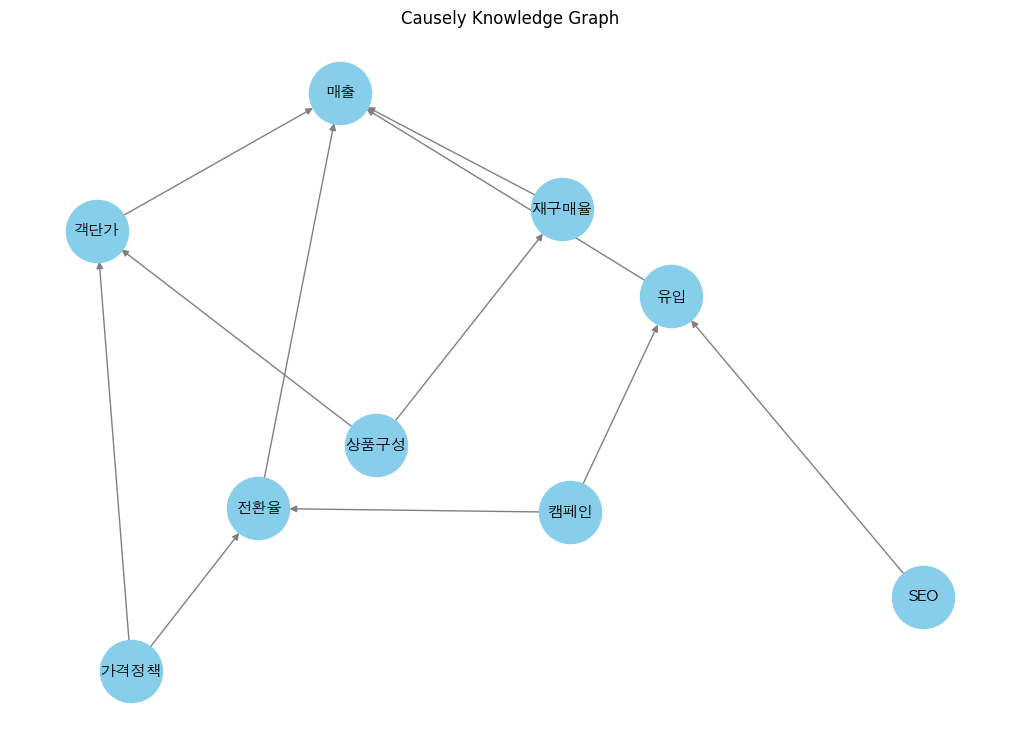

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

def build_knowledge_graph():
    G = nx.DiGraph()
    
    # 노드 추가
    nodes = [
        ("매출", {"type": "root"}),
        ("유입", {"type": "metric"}),
        ("전환율", {"type": "metric"}),
        ("객단가", {"type": "metric"}),
        ("재구매율", {"type": "metric"}),
        ("캠페인", {"type": "cause"}),
        ("가격정책", {"type": "cause"}),
        ("상품구성", {"type": "cause"}),
        ("SEO", {"type": "cause"}),
    ]
    G.add_nodes_from(nodes)
    
    # 엣지 추가 (인과관계)
    edges = [
        ("유입", "매출"),
        ("전환율", "매출"),
        ("객단가", "매출"),
        ("재구매율", "매출"),
        ("캠페인", "유입"),
        ("캠페인", "전환율"),
        ("가격정책", "전환율"),
        ("가격정책", "객단가"),
        ("상품구성", "객단가"),
        ("상품구성", "재구매율"),
        ("SEO", "유입"),
    ]
    G.add_edges_from(edges)
    
    return G

G = build_knowledge_graph()

# 시각화
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color="skyblue", 
        node_size=2000, font_size=11, arrows=True, 
        edge_color="gray", font_family="AppleGothic")
plt.title("Causely Knowledge Graph")
plt.show()

In [4]:
from openai import OpenAI
import os
from dotenv import load_dotenv

load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

def detect_anomalies(df):
    """전주 대비 20% 이상 변한 지표 찾기"""
    metrics = ["revenue", "traffic", "conversion_rate", "avg_order_value", "returning_rate"]
    
    this_week = df.tail(7)[metrics].mean()
    last_week = df.head(7)[metrics].mean()
    
    anomalies = {}
    for metric in metrics:
        change = (this_week[metric] - last_week[metric]) / last_week[metric] * 100
        anomalies[metric] = round(change, 1)
    
    return anomalies

def analyze_with_llm(anomalies, G):
    """이상 감지 결과 + 그래프 구조를 LLM에 던져서 원인 분석"""
    
    graph_structure = list(G.edges())
    
    prompt = f"""
당신은 비즈니스 데이터 분석 전문가입니다.
아래는 이번 주 vs 지난 주 지표 변화율(%)입니다:

{anomalies}

아래는 지표 간 인과관계 구조입니다:
{graph_structure}

위 데이터를 바탕으로:
1. 가장 심각한 문제가 무엇인지
2. 근본 원인이 무엇인지 (Knowledge Graph 기반으로 추론)
3. 권장 액션이 무엇인지

3-4문장으로 명확하게 설명해주세요.
"""
    
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content

# 실행
df = generate_weekly_data()
anomalies = detect_anomalies(df)
print("📊 지표 변화율:")
for k, v in anomalies.items():
    print(f"  {k}: {v}%")

print("\n🤖 AI 분석:")
result = analyze_with_llm(anomalies, G)
print(result)

📊 지표 변화율:
  revenue: -33.1%
  traffic: -21.3%
  conversion_rate: -13.2%
  avg_order_value: 0.9%
  returning_rate: -10.3%

🤖 AI 분석:
가장 심각한 문제는 매출(revenue)이 33.1% 감소한 것입니다. 이는 주로 유입(traffic)의 21.3% 감소에 기인할 수 있으며, 유입 감소는 '캠페인' 또는 'SEO'에 문제가 있을 가능성을 시사합니다. 전환율(conversion_rate) 또한 13.2% 감소하여, 전환율 감소가 매출에 부정적인 영향을 미쳤을 수 있습니다. 따라서, 우선적으로 '캠페인'과 'SEO' 전략을 점검 및 최적화하고, 가격정책이나 상품구성을 통해 전환율을 개선하는 것이 권장됩니다.
